In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.animation import PillowWriter, FuncAnimation, FFMpegWriter
from matplotlib import gridspec

## **Inciso 1**

In [39]:
M, N = 50, 50  # Grid size
r, s = 3, 3  # Subregion size (example, unused directly)
# Define a subregion mask (MxN array)
mask = np.ones((M, N), dtype=int)
# Set the 20x20 region in the top-right corner to 0
mask[:20, -20:] = 0

T = 100  # Number of time steps

In [40]:
K = 0.2  # Diffusion speed parameter

In [53]:
# Initialize the probability distribution u0
u0 = np.random.rand(M, N)  # Initial grid, random for demonstration
u0 *= mask

bias_factor = 3  # Higher values bias more towards 0.
u0 = np.power(u0, bias_factor)

# Normalize so that the sum equals 1
u0 = u0 / u0.sum()

In [54]:
def diffusion_simulation_gif(M, N, r, s, u0, K, T, mask):
    """
    Simulates the diffusion process on an MxN grid over T time steps, and returns the history of the grids.

    Arguments:
    - M: Number of rows in the grid.
    - N: Number of columns in the grid.
    - r: Number of rows in the subregion.
    - s: Number of columns in the subregion.
    - u0: Initial MxN grid (sum of elements = 1).
    - K: Diffusion speed parameter (0 <= K <= 1).
    - T: Number of time steps.
    - mask: MxN bit mask representing the subregion (1 for active, 0 for inactive).

    Returns:
    - history: List of MxN grids at each time step.
    """

    # Helper function to get 8 neighbors sum
    def get_neighbors_sum(u, i, j):
        neighbors = [
            (i-1, j-1), (i-1, j), (i-1, j+1),
            (i, j-1),           (i, j+1),
            (i+1, j-1), (i+1, j), (i+1, j+1)
        ]
        sum_neighbors = 0
        for ni, nj in neighbors:
            if 0 <= ni < M and 0 <= nj < N:
                sum_neighbors += u[ni, nj]
        return sum_neighbors

    # Initialize u with the initial probability distribution u0
    u = np.copy(u0)
    history = [np.copy(u)]  # Store each time step

    # Time-stepping loop
    for t in range(T):
        u_new = np.copy(u)  # Create a copy to store the next state

        # Loop through each cell in the subregion defined by the mask
        for i in range(M):
            for j in range(N):
                if mask[i, j]:  # Only update cells in the active subregion
                    neighbors_sum = get_neighbors_sum(u, i, j)
                    u_new[i, j] = (1 - K) * u[i, j] + (K / 8) * neighbors_sum

        # Apply the mask: set all positions where mask == 0 to 0
        u_new *= mask

        # Update the grid
        u = u_new
        history.append(np.copy(u))  # Save each timestep

    return history


GIF created and saved as 'diffusion_simulation.gif'


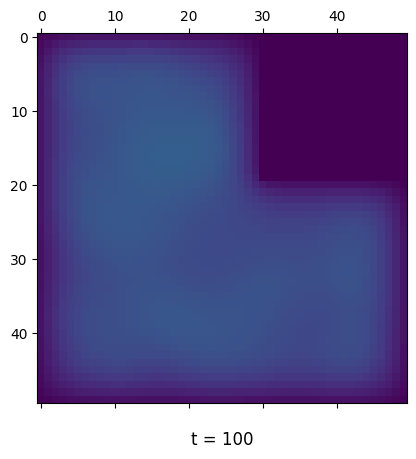

In [55]:
# Run the diffusion simulation
history = diffusion_simulation_gif(M, N, r, s, u0, K, T, mask)

# Set up the figure and axes
fig, ax = plt.subplots()
cax = ax.matshow(history[0], cmap='viridis')
time_text = ax.text(0.5, -0.1, '', ha='center', va='center', transform=ax.transAxes, fontsize=12)

# Initialize plot with the first frame
def init():
    cax.set_array(history[0])
    time_text.set_text('t = 0')
    return [cax, time_text]

# Update function for each frame
def update(frame):
    cax.set_array(history[frame])
    time_text.set_text(f't = {frame}')
    return [cax, time_text]

# Create the animation
ani = FuncAnimation(fig, update, frames=len(history), init_func=init, blit=True)

# Save the animation as a gif
ani.save("diffusion_simulation.gif", writer=PillowWriter(fps=5))

print("GIF created and saved as 'diffusion_simulation.gif'")


## **Inciso 2**

In [56]:
N_exp = 5000
P = 50

In [57]:
def initialize_particles(M, N, u0, P):
    flat_u0 = u0.flatten()
    positions = np.arange(M * N)
    particle_positions = np.random.choice(positions, size=P, p=flat_u0)
    particles = [(pos // N, pos % N) for pos in particle_positions]
    return particles

In [58]:
def move_particle(particle, M, N, K, mask):
    i, j = particle
    if random.random() > K:
        return (i, j)
    neighbors = [
        (i-1, j-1), (i-1, j), (i-1, j+1),
        (i, j-1),            (i, j+1),
        (i+1, j-1), (i+1, j), (i+1, j+1)
    ]
    valid_neighbors = [(ni, nj) for ni, nj in neighbors if 0 <= ni < M and 0 <= nj < N and mask[ni, nj] != 0]
    return random.choice(valid_neighbors)

In [59]:
def simulate_diffusion(M, N, u0, P, K, T, mask):
    particles = initialize_particles(M, N, u0, P)
    history = []
    for t in range(T):
        grid = np.zeros((M, N))
        new_particles = []
        for particle in particles:
            new_particle = move_particle(particle, M, N, K, mask)
            new_particles.append(new_particle)
            grid[new_particle] += 1
        history.append(grid)
        particles = new_particles
    return history

In [60]:
def simulate_multiple_runs(M, N, u0, P, K, T, N_exp, mask):
    avg_grid = np.zeros((T, M, N))
    for _ in range(N_exp):
        history = simulate_diffusion(M, N, u0, P, K, T, mask)
        for t in range(T):
            avg_grid[t] += history[t]
    # Scale by N_exp and normalize
    for t in range(T):
      avg_grid[t] /= avg_grid[t].sum()
    avg_grid /= N_exp
    avg_grid /= avg_grid.sum(axis=(1, 2), keepdims=True)  # Normalize
    return avg_grid

In [61]:
def generate_video(M, N, edp_history, T, filename="diffusion_comparison.mp4"):
    fig, ax = plt.subplots()
    cax = ax.matshow(avg_grid[0], cmap='viridis')
    time_text = ax.text(0.5, -0.1, '', ha='center', va='center', transform=ax.transAxes, fontsize=12)

    def update(frame):
        cax.set_data(edp_history[frame])
        time_text.set_text(f't = {frame}')
        return [cax, time_text]

    writer = FFMpegWriter(fps=5)
    with writer.saving(fig, filename, dpi=100):
        for t in range(T):
            update(t)
            writer.grab_frame()

Video created and saved as 'particule_simulation.mp4'


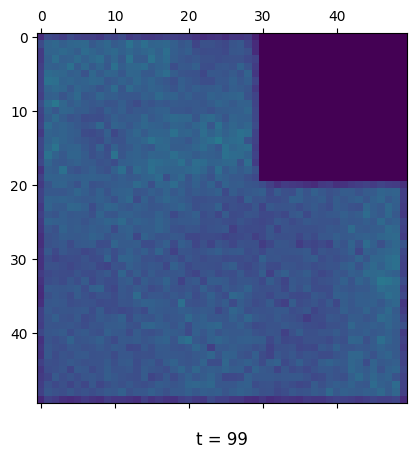

In [62]:
# Run particle simulation
avg_grid = simulate_multiple_runs(M, N, u0, P, K, T, N_exp, mask)

# Comparative video generation
generate_video(M, N, avg_grid, T, filename="particule_simulation.mp4")

print("Video created and saved as 'particule_simulation.mp4'")


## **Inciso 3**

In [63]:
def generate_side_by_side_video(M, N, avg_grid, history, T, filename="diffusion_comparison_side_by_side.mp4"):
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    cax1 = ax1.matshow(avg_grid[0], cmap='viridis')
    cax2 = ax2.matshow(history[0], cmap='viridis')

    ax1.set_title('Particle Simulation')
    ax2.set_title('Diffusion Grid')

    time_text1 = ax1.text(0.5, -0.1, '', ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    time_text2 = ax2.text(0.5, -0.1, '', ha='center', va='center', transform=ax2.transAxes, fontsize=12)

    def update(frame):
        # Update the data in the existing matshow plots
        cax1.set_data(avg_grid[frame])
        cax2.set_data(history[frame])

        # Update the time labels
        time_text1.set_text(f't = {frame}')
        time_text2.set_text(f't = {frame}')

    writer = FFMpegWriter(fps=5)
    with writer.saving(fig, filename, dpi=100):
        for t in range(T):
            update(t)
            writer.grab_frame()

Side-by-side video created as 'diffusion_comparison_side_by_side.mp4'


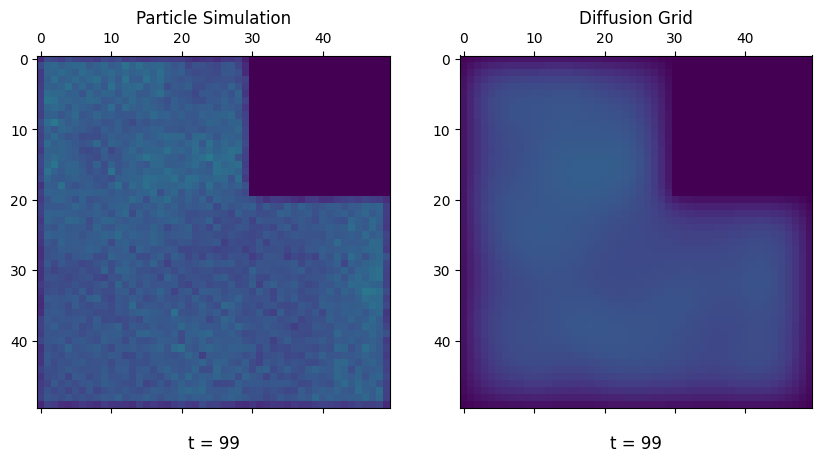

In [64]:
# Generate side-by-side video
generate_side_by_side_video(M, N, avg_grid, history, T, filename="diffusion_comparison_side_by_side.mp4")

print("Side-by-side video created as 'diffusion_comparison_side_by_side.mp4'")